Homework 2:  Implement k-nearest neighbors using the scikit package.

The primary code to address the required homework questions are given in this notebook instance, as well as the analysis required for question #6. 

As an additional exercise, I wrote up an implementation of k-means, and have included in the current directory for review. Sample output plots, ('kMeans_for_#Centroids*.png'), of the k-means algorithm are included that show expected results using the tulip data set. I did not do extra credit problem 7 since the k-means algorithm took a significant amount of effort and I needed to allocate some time to work on my project.

Author: Jose Solomon

In [1]:
# Standard import statements
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import math
#from seaborn import plt
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, feature_selection
from sklearn.cross_validation import train_test_split, cross_val_score

In [2]:
# 1. Implement KNN classification, using the sklearn package.

# Load data
irisRaw = datasets.load_iris()
irisDF = pd.DataFrame(irisRaw.data, columns=irisRaw.feature_names)
irisDF['Target'] = irisRaw.target
irisDF.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


In [3]:
# Define a range of nearest neighbors
nNeighbors = range(1,51,2)

# Use 'sklearn' package to create the test/train split
xTrain, xTest, yTrain, yTest = train_test_split(irisRaw.data, irisRaw.target, test_size=0.3, random_state=12)

# Review the break down of test versus training
print "Number of training points: {}".format(xTrain.shape[0])

Number of training points: 105


In [5]:
print "Number of test points: {}".format(xTest.shape[0])

Number of test points: 45


Nearest neighbors which created the most accurate classification without cross validation: 11


(0.9, 1.02)

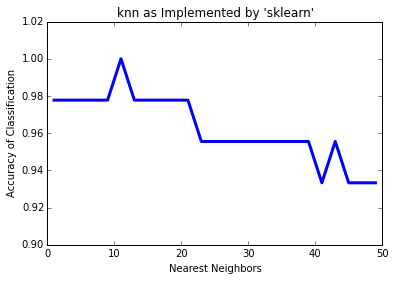

In [6]:
# Use the 'sklearn' knn classifier
scores = []
for n in nNeighbors:
    kNNClassifier = neighbors.KNeighborsClassifier(n)
    kNNClassifier.fit(xTrain, yTrain)
    scores.append(kNNClassifier.score(xTest, yTest))

maxAccuracy = nNeighbors[scores.index(max(scores))]
print "Nearest neighbors which created the most accurate classification without cross validation: {}".format(maxAccuracy)

# Plot results
plt.plot(nNeighbors, scores, linewidth=3.0)
plt.title('knn as Implemented by \'sklearn\'')
plt.ylabel('Accuracy of Classification')
plt.xlabel('Nearest Neighbors')
plt.ylim((0.9,1.02))

In [4]:
# 2. Use the sklearn package to implement cross-validation for your classifier. 
# Use 5 folds for your cross-validation.

# Redefined your sub-dataframe
irisDF = pd.DataFrame(irisRaw.data, columns=irisRaw.feature_names)

# Perform knn with 5-fold cross-validation
kNNClassifier2 = neighbors.KNeighborsClassifier(11, weights='uniform')
kNNClassifier2.fit(irisRaw.data, irisRaw.target)
scores2 = cross_val_score(kNNClassifier2, irisDF.values, irisRaw.target, cv=5)
print scores2
print scores2.mean()

[ 0.93333333  1.          1.          0.96666667  1.        ]
0.98


In [5]:
# 3. Use your KNN classifier and cross-validation code from (1) and (2) above to determine the 
# optimal value of K (number of nearest neighbors to consult) for this Iris dataset.

# Set ranges neighbors
nNeighbors = range(1,51,1)

# Define a total search matrix
totalSearch = np.zeros((1,len(nNeighbors)))
cIndex = 0
# Iterate over neighbors
for k in nNeighbors:
    # Perform knn with f-fold cross-validation
    kNNClassifier3 = neighbors.KNeighborsClassifier(k, weights='uniform')
    kNNClassifier3.fit(irisRaw.data, irisRaw.target)
    meanScores = cross_val_score(kNNClassifier3, irisDF.values, irisRaw.target, cv=5)

    # Take the mean of the scores
    totalSearch[0,cIndex] = meanScores.mean()
    cIndex += 1
    
# Find the optimal K
optimalK = nNeighbors[np.argmax(totalSearch)]
print 'The optimal K using 5-fold cross-validation is {}.'.format(optimalK)

The optimal K using 5-fold cross-validation is 6.


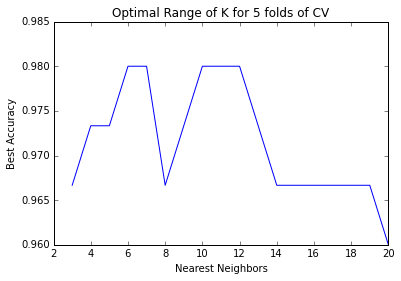

In [6]:
# 4. Using matplotlib, plot classifier accuracy versus the hyperparameter K for a range of K that you
# consider interesting. Explain in words what you are seeing.

# Most interesting range
plt.plot(nNeighbors[2:20],totalSearch[0,2:20])
plt.ylabel('Best Accuracy')
plt.xlabel('Nearest Neighbors')
plt.title('Optimal Range of K for 5 folds of CV')

There seem to be a range of optimal values that are very close together before knn drops off in accuracy past 14. Roughly speaking, sqrt(totalDataPoints) is normally the maxium nearest neigbhor used in practice and we note that sqrt(150) is ~12.25, which is roughly where we see the drop.

In [25]:
# 5. Now, write your own implementation of cross-validation in Python without using the cross-validation methods 
# from sklearn. Compare your cross-validation code with your results using the cross-validation in sklearn.
import random

# Data set size
nPoints = irisDF.shape[0]

# Create a shuffled distribution from 0 to 149
shuffledValues = random.sample(range(nPoints),nPoints)

# Define the number of folds
nFolds = 5

# Break the data into #folds
testBinSize = int(math.floor(nPoints/nFolds))

# Size of training data
trainBinSize = nPoints-testBinSize

# Allocate space for test indices
testDataIndices = np.zeros((nFolds, testBinSize))

# Allocate space for trainining indices
trainDataIndices = np.zeros((nFolds, trainBinSize))

# Create incremenets of test bins and training bins
rIndex = 0
testIndex = 0
totalRange = np.array(range(0,nPoints))
for f in range(0,nFolds):
    # Define ranges -- this is note shuffled
    testRange = range(testIndex,testIndex+testBinSize)
    # Now things are shuffled -- but unique shuffle
    testRange = shuffledValues[testIndex:testIndex+testBinSize]
    trainRange = np.setdiff1d(totalRange,testRange)

    # Store Indices
    testDataIndices[rIndex, :] = testRange;
    trainDataIndices[rIndex, :] = trainRange;
                   
    # Increment counts
    rIndex += 1
    testIndex += testBinSize
    
# Now you have f-fold bin indices, you can run cross-validation using the iris data set
scores = np.zeros((1,nFolds))
for f in range(0,nFolds):
    kNNClassifier = neighbors.KNeighborsClassifier(11, weights='uniform')
    
    # Data values
    xTrain = irisDF.values[trainDataIndices[f,:].astype(int),:]
    xTest = irisDF.values[testDataIndices[f,:].astype(int),:]
    
    # Target values
    yTrain = irisRaw.target[trainDataIndices[f,:].astype(int)]
    yTest = irisRaw.target[testDataIndices[f,:].astype(int)]
    
    # Run classifier
    kNNClassifier.fit(xTrain, yTrain)
    scores[0,f] =(kNNClassifier.score(xTest, yTest))

print scores
print scores.mean()

[[ 1.          0.96666667  0.96666667  1.          1.        ]]
0.986666666667


So the cross validation performance reported here is similar to that of scikit results, with slight variation due to the random shuffle that starts the cross validation routine.

In [ ]:
# 6. __EXTRA CREDIT 1__: Using the value of K obtained in (3) above, vary the number of folds used for 
# cross-validation across an interesting range, e.g. [ 2, 3, 5, 6, 10, 15]. How does classifier accuracy
# vary with the number of folds used? Do you think there exists an optimal number of folds to use for 
# this particular problem? Why or why not?

# I am going to optimize over the number of folds in terms of CV, and then take the fold which has the highest 
# mean per number across the varying number of neighbors and then find the optimal K. A bit convoluted, but this
# can be done in many ways.

# Set ranges neighbors
nNeighbors = range(1,51,1)
# Set range of folds
folds = range(2, 24,1)

# Define a total search matrix
totalSearch = np.zeros((len(folds),len(nNeighbors)))

# Redefined your sub-dataframe
irisDF = pd.DataFrame(irisRaw.data, columns=irisRaw.feature_names)
# scoresCV = np.zeros((len(nNeighbors),10))

# Iterate through cross-validation
rIndex = 0
# Iterate over folds
for f in folds:
    cIndex = 0
    # Iterate over neighbors
    for k in nNeighbors:
        # Perform knn with f-fold cross-validation
        kNNClassifier4 = neighbors.KNeighborsClassifier(k, weights='uniform')
        kNNClassifier4.fit(irisRaw.data, irisRaw.target)
        meanScores = cross_val_score(kNNClassifier4, irisDF.values, irisRaw.target, cv=f)

        # Take the mean of the scores
        totalSearch[rIndex,cIndex] = meanScores.mean()
        cIndex += 1
                
    rIndex += 1

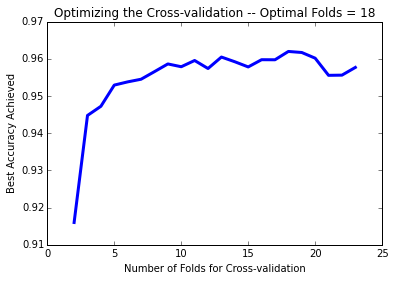

In [58]:
# Take the mean per row of 'totalSearch'... this is the most accurate estimate
bestAccuracy = totalSearch.mean(axis=1)
# Optimal number of folds
plt.plot(folds, bestAccuracy,  linewidth=3.0)
plt.title('Optimizing the Cross-validation -- Optimal Folds = {}'.format(folds[np.argmax(bestAccuracy)]))
plt.ylabel('Best Accuracy Achieved')
plt.xlabel('Number of Folds for Cross-validation')

In [59]:
# Find the optimal K for the optimal fold
bestK = totalSearch[np.argmax(bestAccuracy),:]
print bestK

[ 0.96296296  0.95679012  0.9691358   0.9691358   0.97530864  0.97530864
  0.9691358   0.98148148  0.97530864  0.97530864  0.97530864  0.9691358
  0.9691358   0.97530864  0.97530864  0.9691358   0.97530864  0.97530864
  0.98148148  0.98148148  0.97530864  0.9691358   0.9691358   0.97530864
  0.96296296  0.9691358   0.96296296  0.95061728  0.95679012  0.95679012
  0.95679012  0.95061728  0.95061728  0.95061728  0.95679012  0.95061728
  0.95061728  0.95061728  0.95061728  0.95061728  0.95061728  0.95061728
  0.95679012  0.95061728  0.96296296  0.94444444  0.94444444  0.92592593
  0.94444444  0.94444444]


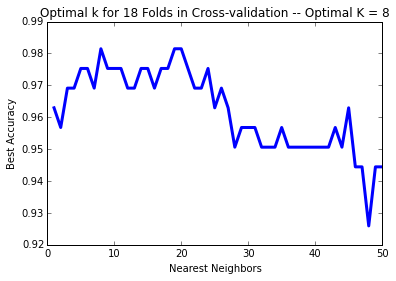

In [60]:
# Optimal nearest neighbor
plt.plot(nNeighbors, bestK,  linewidth=3.0)
plt.title('Optimal k for 18 Folds in Cross-validation -- Optimal K = {}'.format(nNeighbors[np.argmax(bestK)]))
plt.ylabel('Best Accuracy')
plt.xlabel('Nearest Neighbors')


So based on optimizing over the number of folds for cross-validation, and then using the fold that gave the highest overall mean in terms of accuracy, the optimal number of folds is 18 with an optimal k of 8. Interesting enough, this number appears to be insensitive to the 'random state' variable of 'train_test_split'.

Optimal k for 18 folds is 8


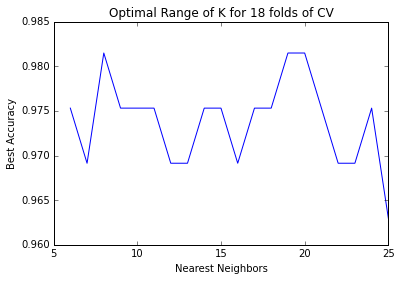

In [63]:
# Plot the results for the optimal fold.
print "Optimal k for 18 folds is {}".format(nNeighbors[np.argmax(bestK)])

# Most interesting range
plt.plot(nNeighbors[5:25],bestK[5:25])
plt.ylabel('Best Accuracy')
plt.xlabel('Nearest Neighbors')
plt.title('Optimal Range of K for 18 folds of CV')


The results posted above are for 18 CV folds, and the there appears to maximums at 8, 19, and 20. The 'np.argmax' give 8 as the optimal folds, but when printing out the optimal accuracy values, the results for 8, 19 and 20 are the same up to 8 decimal places as shown below.

In [386]:
print bestK

[ 0.96296296  0.95679012  0.9691358   0.9691358   0.97530864  0.97530864
  0.9691358   0.98148148  0.97530864  0.97530864  0.97530864  0.9691358
  0.9691358   0.97530864  0.97530864  0.9691358   0.97530864  0.97530864
  0.98148148  0.98148148  0.97530864  0.9691358   0.9691358   0.97530864
  0.96296296  0.9691358   0.96296296  0.95061728  0.95679012  0.95679012
  0.95679012  0.95061728  0.95061728  0.95061728  0.95679012  0.95061728
  0.95061728  0.95061728  0.95061728  0.95061728  0.95061728  0.95061728
  0.95679012  0.95061728  0.96296296  0.94444444  0.94444444  0.92592593
  0.94444444  0.94444444]
